In [109]:
#%matplotlib notebook

In [1]:
import matplotlib
import pymimir as mi
import networkx as nx
import torch
import matplotlib.pyplot as plt
import numpy as np

In [27]:
blocks_instance = "small"
run_name = "06-08_10-20-29"

In [28]:
blocks_domain = mi.DomainParser("../test/pddl_instances/blocks/domain.pddl").parse()
blocks_problem = mi.ProblemParser(
    f"../test/pddl_instances/blocks/{blocks_instance}.pddl").parse(
    blocks_domain)
space = mi.StateSpace.new(blocks_problem, mi.GroundedSuccessorGenerator(blocks_problem))

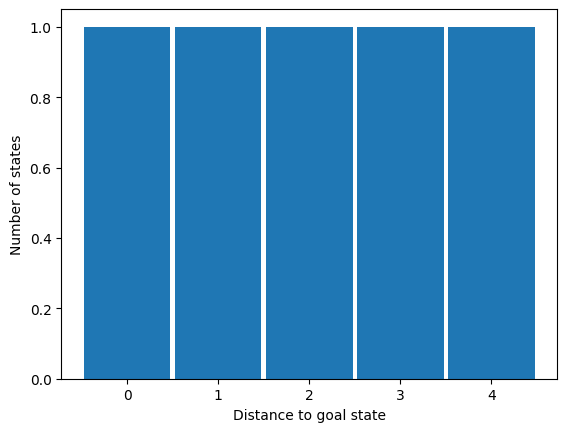

In [29]:
# Draw a histogram over the distances to the goal state
# Display the x-tick number below in the middle of the bars
distances = [space.get_distance_to_goal_state(s) for s in space.get_states()]
unique_distances = len(set(distances))
plt.xlabel("Distance to goal state")
plt.ylabel("Number of states")
plt.hist(distances, bins=np.arange(unique_distances + 1) - 0.5, rwidth=0.95)
plt.xticks(range(unique_distances))
plt.show()

In [30]:
values = torch.load(f"../out/{blocks_instance}/{run_name}/values.pt")

# Investigate values
Values are $\hat V(s) - V(s)$, prediction - optimal

We expect that the initial state starts with a highly negative value and converges to 0, as the actual distance will be greater than the initial prediction (of around 0.5).

In [42]:
values[400,]

tensor([-0.0121, -0.8221,  0.8879, -1.5511])

In [31]:
(total_iterations := len(values))

500

In [32]:
(initial_state_idx := next(
    i for i, s in enumerate(space.get_states()) if s == space.get_initial_state()))

0

In [33]:
initial_values = values[:, initial_state_idx]

In [34]:
(space.get_distance_to_goal_state(space.get_initial_state()),
 max(space.get_distance_to_goal_state(s) for s in space.get_states()))

(2, 4)

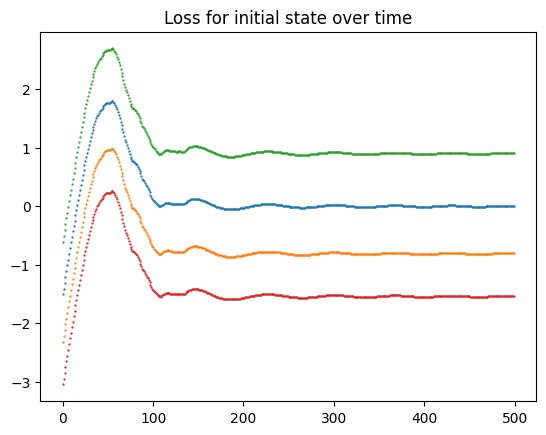

In [35]:
# plot values for initial state over all time steps
# remove outlier
start_it = 0
plt.scatter(torch.arange(start_it, total_iterations), values[start_it:, 0], s=0.4)
plt.scatter(torch.arange(start_it, total_iterations), values[start_it:, 1], s=0.4)
plt.scatter(torch.arange(start_it, total_iterations), values[start_it:, 2], s=0.4)
plt.scatter(torch.arange(start_it, total_iterations), values[start_it:, 3], s=0.4)
plt.title("Loss for initial state over time")
plt.show()

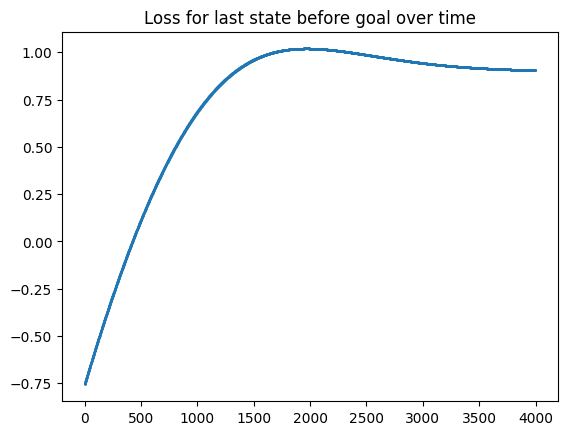

In [12]:
# plot values for last state before the goal over all time steps
one_before_goal = next(i for i, s in enumerate(space.get_states()) if
                       space.get_distance_to_goal_state(s) == 1)
start_it = 0
plt.scatter(torch.arange(start_it, total_iterations),
            values[start_it:, one_before_goal], s=0.4)
plt.title("Loss for last state before goal over time")
plt.show()

In [13]:
space.get_distance_to_goal_state(space.get_states()[124])

IndexError: list index out of range

In [19]:
values[:, 3]

tensor([-3.1955, -3.1935, -3.1915,  ..., -1.5338, -1.5338, -1.5338])

In [14]:
mean_loss = torch.mean(torch.abs(values), dim=1)

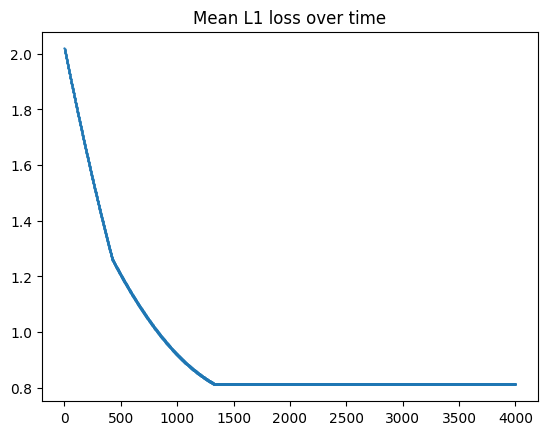

In [15]:
plt.scatter(torch.arange(start_it, total_iterations), mean_loss[start_it:], s=0.4)
plt.title("Mean L1 loss over time")
plt.show()

In [16]:
torch.mean(values[-1]), torch.std(values[-1]), torch.max(values[-1])

(tensor(-0.3571), tensor(1.0504), tensor(0.9052))

# Visualize the state space over time

In [20]:
l1_values = torch.abs(values)
vmax = l1_values.max()

vmin = torch.min(torch.zeros((1,), dtype=torch.float), l1_values.min())
vmax, vmin

(tensor(3.1955), tensor([0.]))

In [21]:
normalized = (l1_values - vmin) / (vmax - vmin)

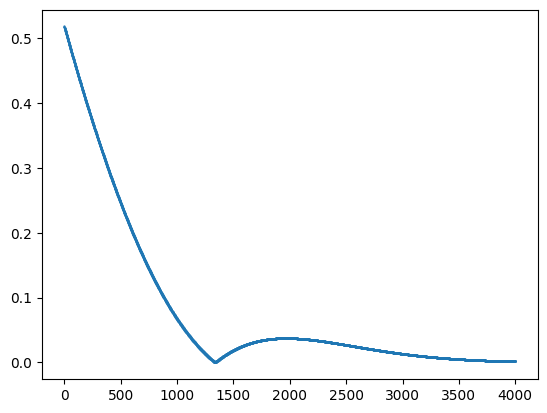

In [22]:
plt.scatter(torch.arange(start_it, total_iterations),
            normalized[start_it:, initial_state_idx], s=0.4)
plt.show()

In [19]:
graph = nx.Graph()
goal_indices = set()
for idx, state in enumerate(space.get_states()):
    if space.is_goal_state(state):
        goal_indices.add(idx)
    graph.add_node(state.__repr__(), idx=idx)
for state in space.get_states():
    for t in space.get_forward_transitions(state):
        graph.add_edge(
            t.source.__repr__(), t.target.__repr__(), action=t.action.schema.name
        )


In [20]:
goal_indices

{4}

In [22]:
def get_value(iteration, index):
    if index in goal_indices:
        return 0.0
    if index == 124:
        return normalized[iteration][index - 1].item()
    return normalized[iteration][index].item()

In [23]:
it_ = 0
get_value(it_, 0), get_value(it_, 1), get_value(it_, 2), get_value(it_, 3), get_value(
    it_, 4)

(0.5789178609848022, 0.800540030002594, 0.3326709568500519, 1.0, 0.0)

In [24]:
pos = nx.spring_layout(graph, seed=42, iterations=2000)

In [25]:
from matplotlib.animation import FuncAnimation


#sm.set_array([])
def update_graph_plot(t, cmap, axis):
    axis.clear()
    # Normalize the values
    # Map node colors
    node_colors = [cmap(get_value(t, attr["idx"])) for _, attr in
                   graph.nodes.data()]

    # Draw the graph
    nx.draw_networkx(graph,
                     pos,
                     node_color=node_colors,
                     nodelist=[n for n in graph.nodes],
                     with_labels=False,
                     node_size=100,
                     ax=axis)

    axis.text(0.95, 0.95, f'Time step: {t}', horizontalalignment='right',
              verticalalignment='top', transform=axis.transAxes, fontsize=12,
              bbox=dict(facecolor='white', alpha=0.5))

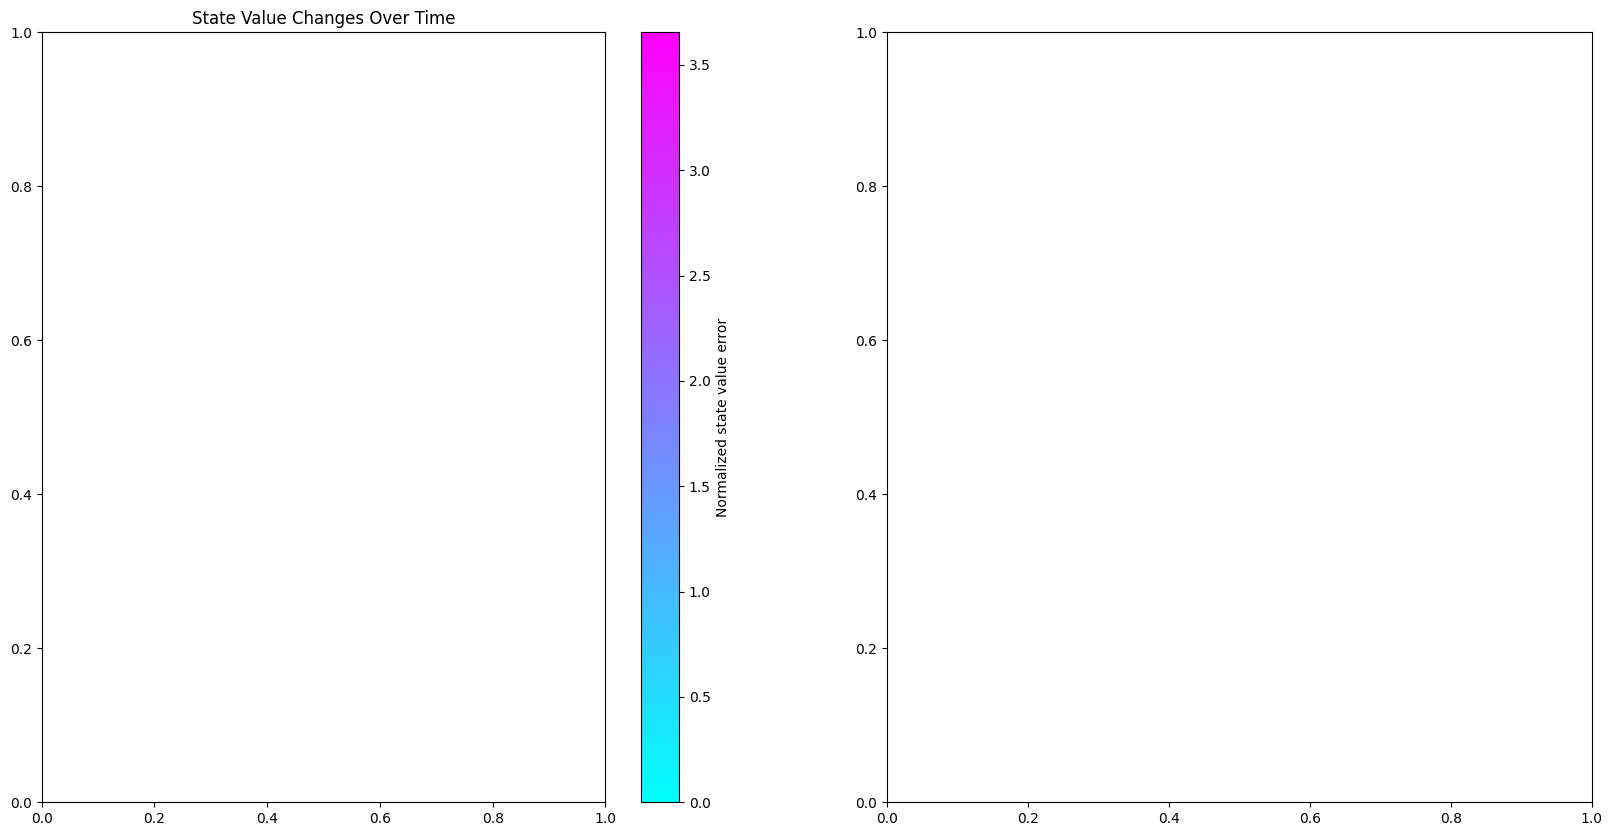

In [26]:
fig, (ax_graph, ax_line) = plt.subplots(figsize=(20, 10), ncols=2)
cmap = plt.cm.cool
normalized_cmap = matplotlib.colors.Normalize(vmin=vmin.item(), vmax=vmax.item())

sm = matplotlib.cm.ScalarMappable(norm=normalized_cmap, cmap=cmap)

ax_graph.set_title('State Value Changes Over Time')
fig.colorbar(sm, ax=ax_graph, orientation="vertical",
             label="Normalized state value error")


In [27]:
line, = ax_line.plot([], [], lw=2)

# Set up loss plot axes limits
ax_line.set_xlim(0, len(mean_loss))
ax_line.set_ylim(mean_loss.min().item(), mean_loss.max().item())
ax_line.set_title("Mean L1 loss over time")
ax_line.set_xlabel("Time step")
ax_line.set_ylabel("Mean L1 loss")


# Initialize your animation
def init():
    line.set_data([], [])
    return line,


def update_line_plot(t, line_data):
    # Update the mean loss line chart
    line_data.set_data(torch.arange(0, t), mean_loss[0:t])
    return line_data

In [28]:
def update(t, cmap, axis, line_data):
    update_graph_plot(t, cmap, axis)
    update_line_plot(t, line_data)
    return line_data

In [29]:
# Create the animation
ani = FuncAnimation(fig, lambda t: update(t, cmap, ax_graph, line), init_func=init,
                    frames=range(0, 2000, 10), repeat=False)

In [30]:
plt.show()

In [32]:
# Save the animation as a GIF
ani.save(f'../out/{blocks_instance}/{run_name}/graph_evolution_{blocks_instance}.gif',
         writer='pillow', fps=6)

In [31]:
len(graph.edges)

4

In [10]:
nx.drawing.nx_pydot.write_dot(graph,
                              "/work/rleap1/jakob.krude/projects/remote/rgnet/out/medium_blocks.dot")

In [82]:
space.get_initial_state().__repr__().split(" ")[1][2:-2]

'2841437515796834589'

In [83]:
out_graph = nx.Graph()


def get_id(s):
    return s.__repr__().split(" ")[1][2:-2]


for idx, state in enumerate(space.get_states()):
    if space.is_goal_state(state):
        type_ = "goal"
    elif space.get_initial_state() == state:
        type_ = "initial"
    else:
        type_ = "default"
    out_graph.add_node(get_id(state), type=type_)
for state in space.get_states():
    for t in space.get_forward_transitions(state):
        out_graph.add_edge(
            get_id(t.source), get_id(t.target), action=t.action.schema.name
        )

out_graph = nx.Graph.copy(out_graph, as_view=False)
nx.convert_node_labels_to_integers(out_graph)
nx.drawing.nx_pydot.write_dot(out_graph, f"../out/{blocks_instance}_blocks.dot")

## Train the supervised case completely in PyTorch as a sanity check

In [23]:
non_goal_states = [s for s in space.get_states() if not space.is_goal_state(s)]
hidden_size = len(non_goal_states)
embeddings = torch.eye(hidden_size)
linear = torch.nn.Linear(hidden_size, 1)
optimal_values = torch.tensor(
    [space.get_distance_to_goal_state(s) for s in space.get_states() if not space.is_goal_state(s)],
    dtype=torch.float)
optim =torch.optim.Adam(linear.parameters(), lr=0.05)
optimal_values

tensor([ 6.,  7.,  7.,  7.,  5.,  6.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
         6.,  6.,  4.,  7.,  5.,  9.,  9.,  9.,  9.,  9.,  7.,  9.,  9.,  9.,
         9.,  9.,  9.,  9.,  9.,  9.,  9.,  7.,  7.,  7.,  7.,  3.,  5.,  8.,
         8.,  6.,  4., 10., 10., 10.,  8., 10., 10., 10., 10., 10., 10.,  8.,
         6., 10.,  8., 10., 10., 10., 10., 10.,  8., 10., 10.,  8., 10., 10.,
        10.,  8.,  8.,  8.,  8.,  2.,  6.,  9.,  7., 11., 11., 11., 11., 11.,
         9., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,  9.,  9.,  9.,
         9.,  1.,  7., 10.,  8., 12., 12., 12., 12., 12., 10., 12., 12., 12.,
        12., 12., 12., 12., 12., 12., 12., 10., 10., 10., 10.,  8.])

In [24]:
history = []
loss_history = []
iterations = 1000
for i in range(iterations):
    predictions = linear(embeddings)
    history.append(predictions.detach())
    loss = torch.nn.functional.l1_loss(predictions.squeeze(), optimal_values)
    loss_history.append(loss.detach())
    if loss < 0.1:
        break
    loss.backward()
    optim.step()
    optim.zero_grad()
    

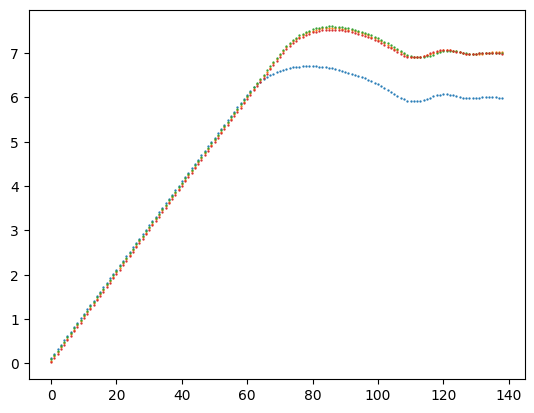

In [25]:
history_length = len(history)
history = torch.stack(history)
plt.scatter(torch.arange(0, history_length),history[:, 0], s=0.4)
plt.scatter(torch.arange(0, history_length),history[:, 1], s=0.4)
plt.scatter(torch.arange(0, history_length),history[:, 2], s=0.4)
plt.scatter(torch.arange(0, history_length),history[:, 3], s=0.4)
plt.show()

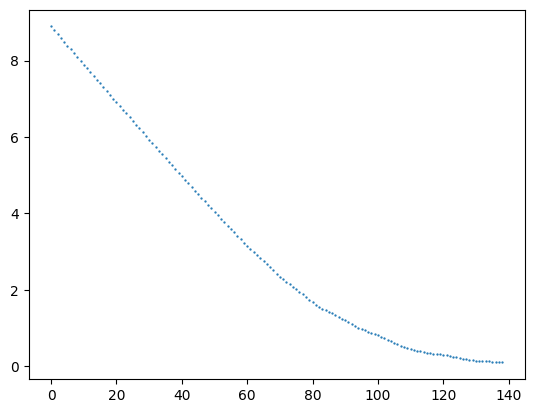

In [26]:
plt.scatter(torch.arange(0, history_length), loss_history, s=0.4)

In [56]:
torch.allclose(history[-1], optimal_values, atol=0.1)

False

In [44]:
history[-1]

tensor([[2.0023],
        [3.0000],
        [0.9964],
        [3.9992]])